In [44]:
from i308_utils import imshow, show_images
from calib import board_points
import cv2
import calib
from calib import np_print
import pickle
import glob
import open3d as o3d
import os
from matplotlib import pyplot as plt 
import numpy as np
import json
from pathlib import Path
from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config


---
# Calibración

In [45]:
checkerboard = (10, 7)
square_size_mm = 24.2
checkerboard_world_points_mm = board_points(checkerboard) * square_size_mm


In [46]:
directory = os.path.join("datasets", "budha_board", "calib")
left_files_pattern = "*left*.jpg"
right_files_pattern = "*right*.jpg"

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

num_left = len(left_file_names)
num_right = len(right_file_names)

if  num_left != num_right:
    raise Exception(f"the number of files (left {num_left} / right{num_right}) doesn't match")

In [47]:
image_size = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

world_points = []
left_images = []
right_images = []
left_images_points = []
right_images_points = []

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):

    print("processing", left_file_name, right_file_name)

    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # get the images sizes
    left_size = (left_image.shape[1], left_image.shape[0])
    right_size = (right_image.shape[1], right_image.shape[0])

    # checks that images sizes match
    if left_size != right_size:
        raise Exception(f"left and right images sizes differ: left {left_size} / right {right_size}")
        
    if image_size is None:
        # remembers the images size
        image_size = left_size
    else:
        if image_size != left_size:
            raise Exception(f"there are images with different sizes: {image_size} vs {left_size}")

    # finds the checkerboard in each image
    left_found, left_corners = cv2.findChessboardCorners(left_image, checkerboard)
    right_found, right_corners = cv2.findChessboardCorners(right_image, checkerboard)

    if not left_found or not right_found:
        print("warning, checkerboard was not found")
        continue

    # checkerboard was found in both images.

    # let's improve the found corners
    corners_left = cv2.cornerSubPix(left_image, left_corners, (7, 7), (-1,-1), criteria)
    corners_right = cv2.cornerSubPix(right_image, right_corners, (7, 7), (-1,-1), criteria)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

    # acumulo los corners detectados
    left_images_points.append(left_corners)
    right_images_points.append(right_corners)

    # acumulo los puntos del mundo
    world_points.append(checkerboard_world_points_mm)


processing datasets/budha_board/calib/calib_left_0.jpg datasets/budha_board/calib/calib_right_0.jpg
processing datasets/budha_board/calib/calib_left_1.jpg datasets/budha_board/calib/calib_right_1.jpg
processing datasets/budha_board/calib/calib_left_2.jpg datasets/budha_board/calib/calib_right_2.jpg
processing datasets/budha_board/calib/calib_left_3.jpg datasets/budha_board/calib/calib_right_3.jpg
processing datasets/budha_board/calib/calib_left_4.jpg datasets/budha_board/calib/calib_right_4.jpg
processing datasets/budha_board/calib/calib_left_5.jpg datasets/budha_board/calib/calib_right_5.jpg
processing datasets/budha_board/calib/calib_left_6.jpg datasets/budha_board/calib/calib_right_6.jpg
processing datasets/budha_board/calib/calib_left_7.jpg datasets/budha_board/calib/calib_right_7.jpg
processing datasets/budha_board/calib/calib_left_8.jpg datasets/budha_board/calib/calib_right_8.jpg
processing datasets/budha_board/calib/calib_left_9.jpg datasets/budha_board/calib/calib_right_9.jpg


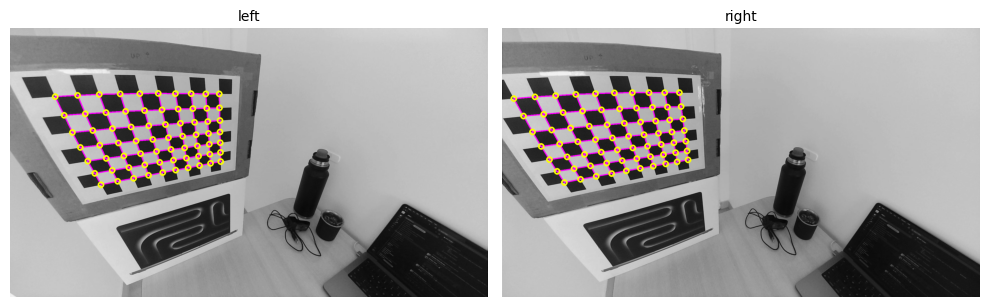

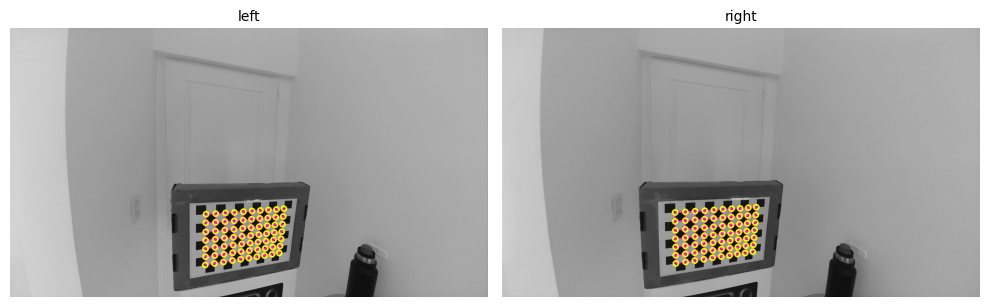

In [48]:
some_images_indices = [5, 14]

draw_settings = {
    "corner_radius": 10,
    "corner_thickness": 5,
    "line_thickness": 4
}
for i in some_images_indices:

    left_img, right_img = left_images[i], right_images[i]
    left_corners, right_corners = left_images_points[i], right_images_points[i]

    show_left = cv2.cvtColor(left_img, cv2.COLOR_GRAY2BGR)
    show_right = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)

    calib.draw_checkerboard(show_left, checkerboard, left_corners, True, **draw_settings)
    calib.draw_checkerboard(show_right, checkerboard, right_corners, True, **draw_settings)
    
    show_images([show_left, show_right], ["left", "right"])

### Calibración con OpenCV

In [49]:
print("Calibrating Stereo")
print("num images:", len(left_images_points))

err, left_K, left_dist, right_K, right_dist, R, T, E, F = cv2.stereoCalibrate(
    world_points, 
    left_images_points, 
    right_images_points, 
    None, 
    None, 
    None, 
    None, 
    image_size, 
    flags=0
) 

to_print = [

    "# Left camera Intrinsics:",
    ("left_K", left_K),
    ("left_dist", left_dist),

    "# Right camera Intrinsics:",
    ("right_K", right_K),
    ("right_dist", right_dist),

    "# Rotation:",
    ("R", R),

    "# Translation:",
    ("T", T),
    
    "# Essential Matrix:",
    ("E", E),
    
    "# Fundamental Matrix:",
    ("F", F),
        
]


Calibrating Stereo
num images: 28


In [50]:
print("# STEREO CALIBRATION")
for line in to_print:

    if isinstance(line, str):   
        print(line)
    else:
        var_name, np_array = line
        print(f"{var_name} = {np_print(np_array)}\n")

# STEREO CALIBRATION
# Left camera Intrinsics:
left_K = np.array([
	[   602.055,	     0.000,	   959.968],
	[     0.000,	   602.877,	   547.379],
	[     0.000,	     0.000,	     1.000]
])

left_dist = np.array([
	[  0.001785,	 -0.021652,	 -0.000756,	  0.000157,	  0.003254]
])

# Right camera Intrinsics:
right_K = np.array([
	[   601.046,	     0.000,	   960.689],
	[     0.000,	   601.785,	   535.522],
	[     0.000,	     0.000,	     1.000]
])

right_dist = np.array([
	[  0.003928,	 -0.023404,	 -0.000589,	  0.000021,	  0.003597]
])

# Rotation:
R = np.array([
	[     1.000,	     0.000,	     0.004],
	[    -0.000,	     1.000,	     0.008],
	[    -0.004,	    -0.008,	     1.000]
])

# Translation:
T = np.array([
	[-59.768746],
	[  0.231093],
	[  0.205344]
])

# Essential Matrix:
E = np.array([
	[    -0.001,	    -0.207,	     0.229],
	[    -0.059,	    -0.474,	    59.767],
	[    -0.222,	   -59.767,	    -0.475]
])

# Fundamental Matrix:
F = np.array([
	[     0.000,	     0.000,	    -0.004],
	[     0.0

In [51]:
calibration_results = {
    'left_K': left_K,
    'left_dist': left_dist,
    'right_K': right_K,
    'right_dist': right_dist,
    'R': R,
    'T': T,
    'E': E,
    'F': F,
    'image_size': image_size,
}

calibration_file = os.path.join("datasets", "budha_board", "stereo_calibration.pkl")
with open(calibration_file, "wb") as f:
    f.write(pickle.dumps(calibration_results))



--- 
# Rectificación

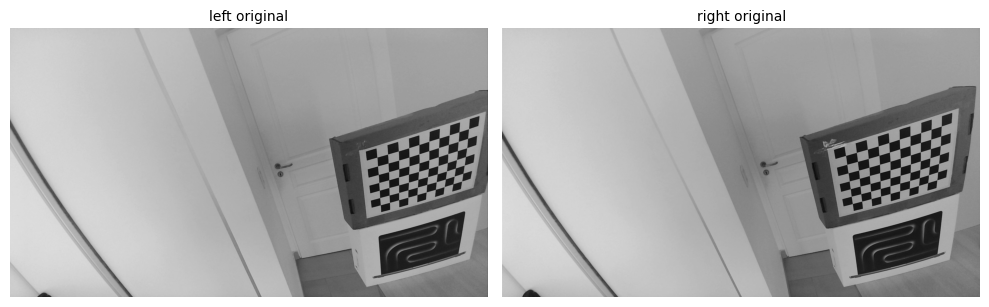

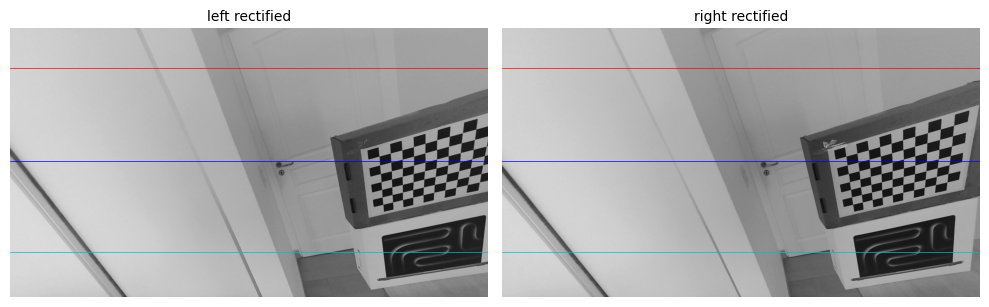

In [52]:

R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist, right_K, right_dist, image_size, R, T, alpha=0
)

left_map_x, left_map_y = cv2.initUndistortRectifyMap(left_K, left_dist, R1, P1, image_size, cv2.CV_32FC1)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(right_K, right_dist, R2, P2, image_size, cv2.CV_32FC1)

image_index = 10 #ejemplo
left_image = left_images[image_index]
right_image = right_images[image_index]

show_images([
    left_image, right_image
], [
    "left original", "right original"
])

left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
], show=False)

for y, c in zip([160, 533, 900], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

In [53]:
stereo_maps = {

    # undistorting maps
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,

    # add also rectifying info:
    "R1": R1,
    "R2": R2,
    "P1": P1,
    "P2": P2,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,

}

stereo_maps_file = os.path.join("datasets", "budha_board", "stereo_maps.pkl")
with open(stereo_maps_file, "wb") as f:
    f.write(pickle.dumps(stereo_maps))

### Ahora con las imágenes del dataset del Budha

reading stereo calibration results...
reading stereo rectification maps...


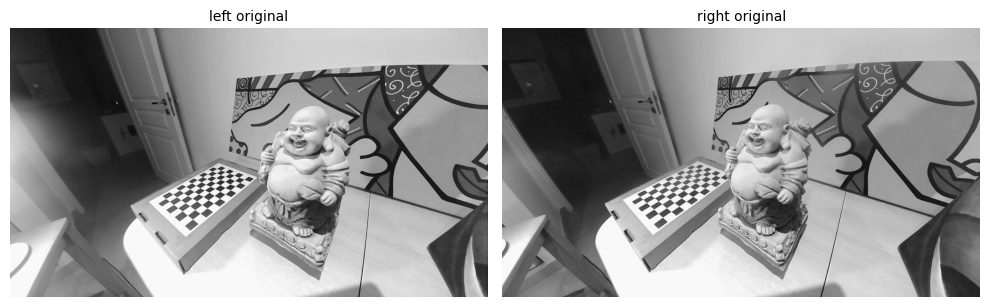

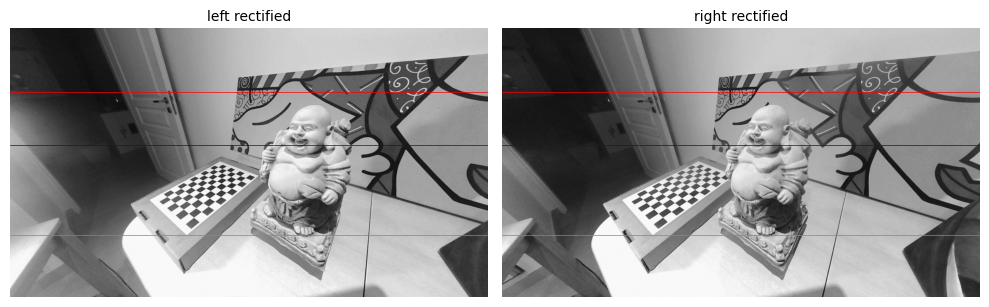

In [54]:
left_image_file = os.path.join("datasets", "budha_board", "captures", "left_3.jpg")
right_image_file = os.path.join("datasets", "budha_board", "captures", "right_3.jpg")

left_image = cv2.imread(left_image_file, 0)
right_image = cv2.imread(right_image_file, 0)

fig, axes = show_images([
    left_image, right_image
], [
    "left original", "right original"
], show=False)


stereo_calib_file = os.path.join("datasets", "budha_board", "stereo_calibration.pkl")
stereo_maps_file = os.path.join("datasets", "budha_board", "stereo_maps.pkl")

print("reading stereo calibration results...")
with open(stereo_calib_file, "rb") as f:
    calibration = pickle.loads(f.read())
    
print("reading stereo rectification maps...")
with open(stereo_maps_file, "rb") as f:
    maps = pickle.loads(f.read())


left_map_x, left_map_y = maps['left_map_x'], maps['left_map_y']
right_map_x, right_map_y = maps['right_map_x'], maps['right_map_y']

left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)


fig, axes = show_images([
    left_image_rectified, right_image_rectified
], [
    "left rectified", "right rectified"
], show=False)

for y, c in zip([255, 470, 830], ['r', 'b', 'c']):
    axes[0].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
    axes[1].axhline(y=y, color=c, linestyle='-', linewidth=0.5)
plt.show()

---
# Cálculo de disparidad

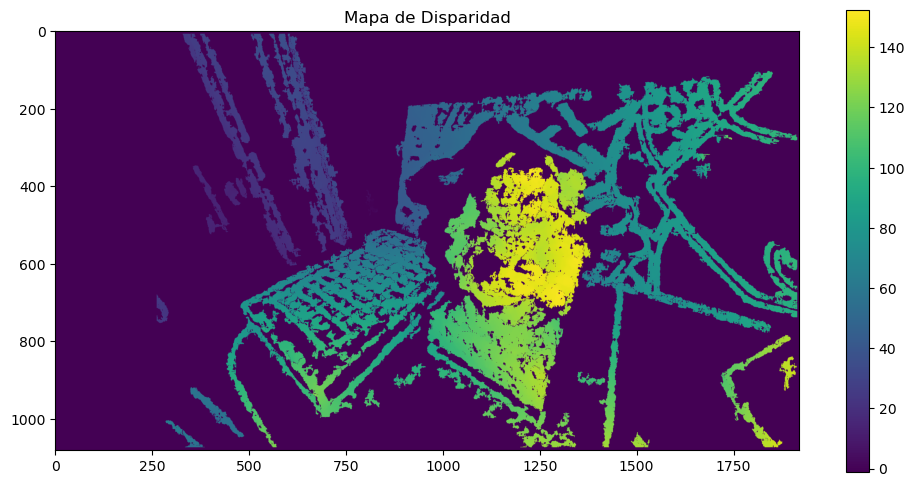

In [55]:
stereo = cv2.StereoBM_create(
    numDisparities=256,
    blockSize=15,
)

stereo.setPreFilterSize(31)
stereo.setPreFilterCap(15)
stereo.setMinDisparity(0)
stereo.setTextureThreshold(7)
stereo.setUniquenessRatio(3)
stereo.setSpeckleWindowSize(512)
# stereo.setSpeckleWindowSize(0)
stereo.setSpeckleRange(32)
stereo.setDisp12MaxDiff(23)


# Cálculo del mapa de disparidad
disparity_map = stereo.compute(
    left_image_rectified, 
    right_image_rectified
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map)
plt.title("Mapa de Disparidad")
plt.colorbar()
plt.show()

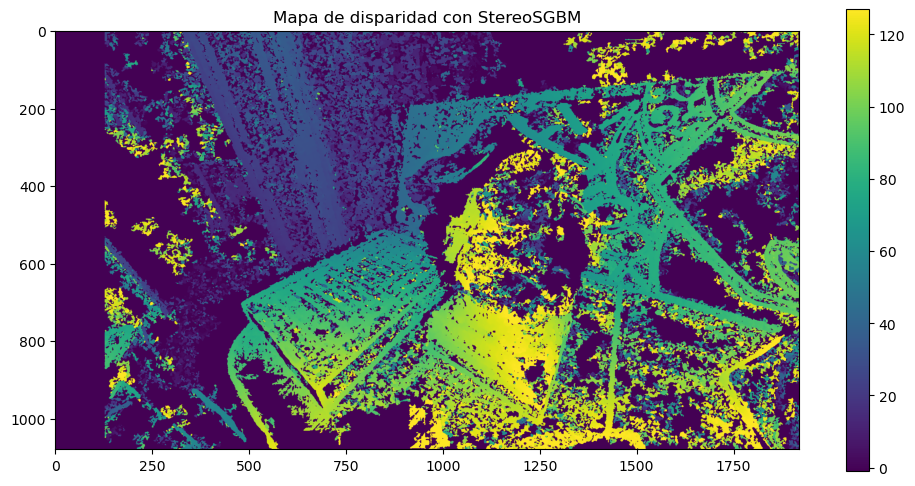

In [56]:

stereo = cv2.StereoSGBM_create(
    numDisparities=128,
    blockSize=7
)

stereo.setP1(16)
stereo.setP2(128)
stereo.setUniquenessRatio(7)
stereo.setSpeckleWindowSize(512)
stereo.setSpeckleRange(64)
stereo.setDisp12MaxDiff(1)
stereo.setPreFilterCap(63)

# Cálculo del mapa de disparidad
disparity_map = stereo.compute(
    left_image_rectified, 
    right_image_rectified
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.title("Mapa de disparidad con StereoSGBM")
plt.imshow(disparity_map)
plt.colorbar()
plt.show()

models/crestereo_combined_iter5_720x1280.onnx


/Users/titigrune/miniconda3/envs/global_env/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


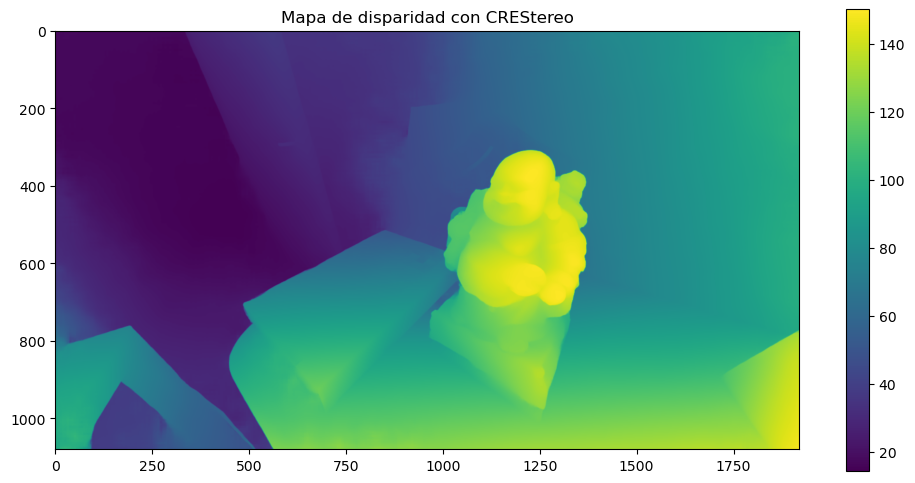

In [57]:
w, h = left_image.shape[1], left_image.shape[0]

fx = left_K[0][0]
fy = left_K[1][1]
cx0 = left_K[0][2]
cy0 = left_K[1][2]

baseline = np.linalg.norm(T)

calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

#models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)
pair = InputPair(left_image_rectified, right_image_rectified, calibration)
# pair = InputPair(left_image, right_image, calibration)
config = Config(models_path=models_path)

# params = {
#    "Shape": "1280x720",
#    "Mode": "combined",
#    "Iterations": 20
#}
method = CREStereo(config)

#method.parameters["Shape"].set_value("640x480")
method.parameters["Shape"].set_value("1280x720")
# method.parameters["Iterations"].set_value("10")

#method.parameters.update(params)
# method = StereoBM(config)
# method = StereoSGBM(config)
# method = StereoBM(config)
disparity = method.compute_disparity(pair)

plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.title("Mapa de disparidad con CREStereo")
plt.colorbar()
plt.show()

---
# Cálculo de la profundidad

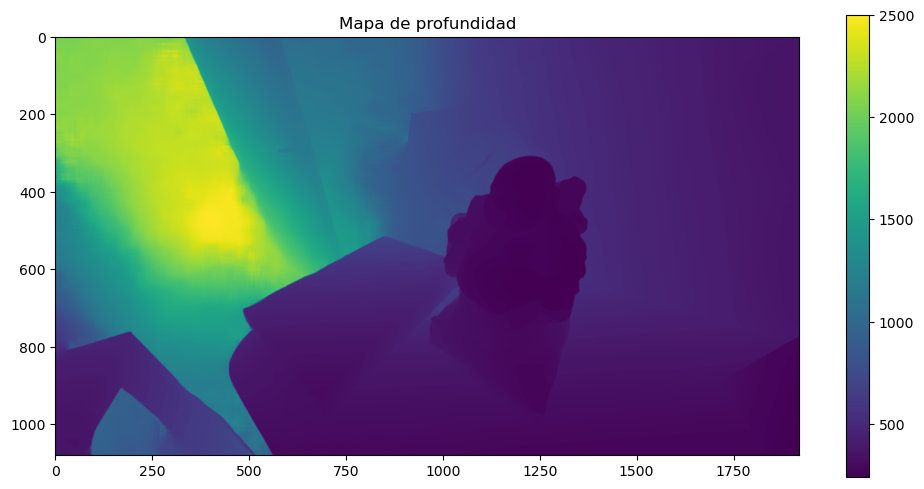

In [58]:
def compute_depth(disparity_map, f, B, default=1000.0):

    # Crea una copia del mapa de disparidad
    disparity_map = disparity_map.copy()
    
    # Evita divisiones por cero o disparidades negativas (les asignamos el valor default)
    mask_invalid = (disparity_map <= 0)
    
    # Calcula la profundidad con la fórmula Z = f * B / disparidad
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    depth_map[~mask_invalid] = (f * B) / disparity_map[~mask_invalid]
    
    # Asigna valor fijo a los puntos donde la disparidad es inválida
    depth_map[mask_invalid] = default
    
    return depth_map

disparity_map = disparity.disparity_pixels

f = left_K[0][0]
B = baseline = np.linalg.norm(T) 

depth = compute_depth(disparity_map, f, B)

plt.figure(figsize=(12, 6))
plt.imshow(depth)
plt.title("Mapa de profundidad")
plt.colorbar()
plt.show()

---
# Pasarlo a 3D

In [ ]:
def export_ply(archivo_ply, depth_map, img_color, f, cx, cy):
    """
    Exporta el mapa de profundidad y la imagen de color a un archivo .PLY.

    Parámetros:
        archivo_ply (str): Ruta del archivo de salida .PLY.
        depth_map (numpy.ndarray): Mapa de profundidad.
        img_color (numpy.ndarray): Imagen original en color.
        f (float): Distancia focal de la cámara (en píxeles).
        cx, cy (float): Coordenadas del centro óptico (en píxeles).
    """
    h, w = depth_map.shape
    with open(archivo_ply, 'w') as f_out:
        # cabecera del archivo .PLY
        f_out.write('ply\n')
        f_out.write('format ascii 1.0\n')
        f_out.write(f'element vertex {h * w}\n')
        f_out.write('property float x\n')
        f_out.write('property float y\n')
        f_out.write('property float z\n')
        f_out.write('property uchar red\n')
        f_out.write('property uchar green\n')
        f_out.write('property uchar blue\n')
        f_out.write('end_header\n')

        for y in range(h):
            for x in range(w):
                Z = depth_map[y, x]
                if Z == 0:  # skippea píxeles con profundidad 0
                    continue
                
                # convierte coordenadas de píxel a coordenadas de mundo 3D
                X = (x - cx) * Z / f
                Y = (y - cy) * Z / f

                # color de la imagen original (en BGR)
                color = img_color[y, x]
                r, g, b = color[2], color[1], color[0]

                # escribie el punto 3D y su color al archivo PLY
                f_out.write(f'{X} {Y} {Z} {r} {g} {b}\n')

    print(f'Archivo .PLY guardado como {archivo_ply}')


left_image_color = cv2.imread(left_image_file)
left_image_color_rectified = cv2.remap(left_image_color, left_map_x, left_map_y, cv2.INTER_LINEAR)

export_ply(
    "datasets/budha_board/budha.ply",
    depth,
    left_image_color_rectified,
    left_K[0, 0],
    left_K[0, 2],
    left_K[1, 2],
)



Archivo .PLY guardado como datasets/budha_board/budha.ply


Mustra de como se ve un set de fotos stereo pasado a una archivo .ply

In [60]:
pcd = o3d.io.read_point_cloud("datasets/budha_board/budha.ply")
o3d.visualization.draw_geometries([pcd])

# IMPORTANTE 
El archivo `.ply` no se incluye en el repositorio por su tamaño. 
Podés regenerarlo ejecutando las celdas del notebook.

--- 
# LO HACEMOS PARA TODOS LOS PARES DE IMÁGENES BUDHA


In [61]:
left_images = sorted(glob.glob("datasets/budha_board/captures/left_*.jpg"))
right_images = sorted(glob.glob("datasets/budha_board/captures/right_*.jpg"))

stereo_calib_file = os.path.join("datasets", "budha_board", "stereo_calibration.pkl")
stereo_maps_file = os.path.join("datasets", "budha_board", "stereo_maps.pkl")

with open(stereo_calib_file, "rb") as f:
    calib_data = pickle.loads(f.read())

with open(stereo_maps_file, "rb") as f:
    maps = pickle.loads(f.read())

left_K = calib_data["left_K"]
T = calib_data["T"]
fx = left_K[0, 0]
fy = left_K[1, 1]
cx0 = left_K[0, 2]
cy0 = left_K[1, 2]
baseline = np.linalg.norm(T) / 1000  

for i, (l_path, r_path) in enumerate(zip(left_images, right_images)):
    left = cv2.imread(l_path)
    right = cv2.imread(r_path)

    left_map_x, left_map_y = maps['left_map_x'], maps['left_map_y']
    right_map_x, right_map_y = maps['right_map_x'], maps['right_map_y']

    left_rect = cv2.remap(left, left_map_x, left_map_y, cv2.INTER_LINEAR)
    right_rect = cv2.remap(right, right_map_x, right_map_y, cv2.INTER_LINEAR)

    h, w = left.shape[:2]

    calib_obj = Calibration(**{
        "width": w,
        "height": h,
        "baseline_meters": baseline,
        "fx": fx,
        "fy": fy,
        "cx0": cx0,
        "cx1": cx0,
        "cy": cy0,
        "depth_range": [0.05, 20.0],
        "left_image_rect_normalized": [0, 0, 1, 1]
    })

    models_path = Path("models")
    models_path.mkdir(exist_ok=True)

    pair = InputPair(left_rect, right_rect, calib_obj)
    config = Config(models_path=models_path)
    method = CREStereo(config)
    method.parameters["Shape"].set_value("1280x720")
    disparity = method.compute_disparity(pair)

    disparity_map = disparity.disparity_pixels
    depth = compute_depth(disparity_map, fx, baseline)

    export_ply(
        f"datasets/budha_board/ply_output/scene_{i}.ply",
        depth,
        left_rect,
        fx, cx0, cy0,
    )


models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_0.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_1.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_2.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_3.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_4.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_5.ply


Todas las representaciones de los pares de imágenes stereo en 3D

In [62]:
for i in range(len(left_images)):
    pcd = o3d.io.read_point_cloud(f"datasets/budha_board/ply_output/scene_{i}.ply")
    o3d.visualization.draw_geometries([pcd])


## Hago lo mismo que antes pero tomando 3 puntos y sus coordenadas en 3D que estén en todas las imágenes así puedo usarlo para la reconstrucción. Elijo usar 3 puntos del checkerboard. 
### No puede ser 1 ni 2 porque no aseguran que tenga en cuenta la rotación o escalación, pero con 3 puntos se puede recrear toda la escena. 

In [63]:
left_images = sorted(glob.glob("datasets/budha_board/captures/left_*.jpg"))
right_images = sorted(glob.glob("datasets/budha_board/captures/right_*.jpg"))

with open("datasets/budha_board/stereo_calibration.pkl", "rb") as f:
    calib_data = pickle.load(f)

with open("datasets/budha_board/stereo_maps.pkl", "rb") as f:
    maps = pickle.load(f)

left_K = calib_data["left_K"]
T = calib_data["T"]
fx = left_K[0, 0]
fy = left_K[1, 1]
cx0 = left_K[0, 2]
cy0 = left_K[1, 2]
baseline = np.linalg.norm(T) / 1000

checkerboard_3d_points = []
checkerboard_size = (10, 7) 

for i, (l_path, r_path) in enumerate(zip(left_images, right_images)):
    left = cv2.imread(l_path)
    right = cv2.imread(r_path)

    left_map_x, left_map_y = maps['left_map_x'], maps['left_map_y']
    right_map_x, right_map_y = maps['right_map_x'], maps['right_map_y']

    left_rect = cv2.remap(left, left_map_x, left_map_y, cv2.INTER_LINEAR)
    right_rect = cv2.remap(right, right_map_x, right_map_y, cv2.INTER_LINEAR)

    h, w = left.shape[:2]

    calib_obj = Calibration(**{
        "width": w,
        "height": h,
        "baseline_meters": baseline,
        "fx": fx,
        "fy": fy,
        "cx0": cx0,
        "cx1": cx0,
        "cy": cy0,
        "depth_range": [0.05, 20.0],
        "left_image_rect_normalized": [0, 0, 1, 1]
    })

    pair = InputPair(left_rect, right_rect, calib_obj)
    config = Config(models_path=Path("models"))
    method = CREStereo(config)
    method.parameters["Shape"].set_value("1280x720")
    disparity = method.compute_disparity(pair)

    disparity_map = disparity.disparity_pixels
    depth = compute_depth(disparity_map, fx, baseline)

    gray = cv2.cvtColor(left_rect, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(gray, checkerboard_size)

    puntos = []
    if found and corners.shape[0] == checkerboard_size[0] * checkerboard_size[1]:
        idxs = [0, 60, 69]  

        for idx in idxs:
            x, y = map(int, corners[idx][0])
            z = depth[y, x]
            if z > 0 and not np.isnan(z):
                X = (x - cx0) * z / fx
                Y = (y - cy0) * z / fx
                puntos.append([X, Y, z])
            
    checkerboard_3d_points.append(puntos)

    export_ply(
        f"datasets/budha_board/ply_output/scene_{i}.ply",
        depth,
        left_rect,
        fx, cx0, cy0,
    )

with open("datasets/budha_board/checkerboard_3d_points_3.pkl", "wb") as f:
    pickle.dump(checkerboard_3d_points, f)

print("Guardado: checkerboard_3d_points_3.pkl con 3 puntos 3D por escena")


models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_0.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_1.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_2.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_3.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_4.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/budha_board/ply_output/scene_5.ply
Guardado: checkerboard_3d_points_3.pkl con 3 puntos 3D por escena


### Visualización de los 3 puntos para cada representación 3D

In [64]:
with open("datasets/budha_board/checkerboard_3d_points_3.pkl", "rb") as f:
    puntos_3d = pickle.load(f)

# colores distintos para los tres puntos
colores = [[1, 0, 0], [0, 1, 0],[0, 0, 1]]

for i, tripleta in enumerate(puntos_3d):
    ply_path = f"datasets/budha_board/ply_output/scene_{i}.ply"
    pcd = o3d.io.read_point_cloud(ply_path)

    esferas = []
    if tripleta is not None and all(p is not None for p in tripleta):
        for j, punto in enumerate(tripleta):
            esfera = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
            esfera.translate(punto)
            esfera.paint_uniform_color(colores[j % len(colores)])
            esferas.append(esfera)

        print(f"Los 3 puntos en la escena {i}")
        o3d.visualization.draw_geometries([pcd] + esferas)

Los 3 puntos en la escena 0
Los 3 puntos en la escena 1
Los 3 puntos en la escena 2
Los 3 puntos en la escena 3
Los 3 puntos en la escena 4
Los 3 puntos en la escena 5


Algoritmo Umeyama para alinear dos sets de puntos 3D. Lo aplico con todas las nubes de puntos sobre una nube base. 

In [65]:

def rigid_transform_3D(A, B):
    assert A.shape == B.shape
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T


In [66]:
with open("datasets/budha_board/checkerboard_3d_points_3.pkl", "rb") as f:
    puntos_3d_por_nube = pickle.load(f)

ply_files = sorted(glob.glob("datasets/budha_board/ply_output/scene_*.ply"))
pcd_base = o3d.io.read_point_cloud(ply_files[0]) #la nube de la escena 0 es mi base para la reconstrucción 3D con todas las nubes alineadas
base_points = np.array(puntos_3d_por_nube[0])  

pcd_resultado = pcd_base  

for i in range(1, len(ply_files)):
    puntos_actuales = puntos_3d_por_nube[i]
    src_pts = np.array(puntos_actuales) 
    dst_pts = base_points               

    T = rigid_transform_3D(src_pts, dst_pts)

    pcd = o3d.io.read_point_cloud(ply_files[i])
    pcd.transform(T)
    pcd_resultado += pcd
    print(f"Escena {i} alineada")

o3d.visualization.draw_geometries([pcd_resultado])
o3d.io.write_point_cloud("datasets/budha_board/reconstruccion_alineada.ply", pcd_resultado)
print("Nube completa: 'reconstruccion_alineada.ply'")


Escena 1 alineada
Escena 2 alineada
Escena 3 alineada
Escena 4 alineada
Escena 5 alineada
Nube completa: 'reconstruccion_alineada.ply'



---
# Visualizaciones

### Representación de la escena completa con un Bounding Box + Mapa de calor por distancia + suavizado

In [67]:
pcd = o3d.io.read_point_cloud("datasets/budha_board/reconstruccion_alineada.ply")
with open("datasets/budha_board/checkerboard_3d_points_3.pkl", "rb") as f:
    puntos_3d = pickle.load(f)

primer_punto = np.array(puntos_3d[0][0])

umbral = 0.7 # bounding box 70 cm alrededor del punto del checkerboard
min_bound = primer_punto - umbral
max_bound = primer_punto + umbral
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)
pcd_recortada = pcd.crop(bbox)

# suavizado
pcd_filtrada, _ = pcd_recortada.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_filtrada = pcd_filtrada.voxel_down_sample(voxel_size=0.005)

# colorear por distancia al origen
points = np.asarray(pcd_filtrada.points)
distancias = np.linalg.norm(points - primer_punto, axis=1)
d_norm = (distancias - distancias.min()) / (distancias.max() - distancias.min())
colors = plt.cm.plasma(d_norm)[:, :3]
pcd_filtrada.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd_filtrada])


### Suavizado sobre la imagen: eliminación de puntos aislados o también conocidas como "esas particulas que aparecen en Infinity War cuando Thanos chasquea los dedos"

In [68]:
pcd = o3d.io.read_point_cloud("datasets/budha_board/reconstruccion_alineada.ply")
pcd_filtrada1, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
o3d.visualization.draw_geometries([pcd_filtrada1])
o3d.io.write_point_cloud("datasets/budha_board/reconstruccion_alineada_sin_puntitos.ply", pcd_filtrada1)

True

### Filtro de Poisson

In [69]:
pcd_filtrada1.estimate_normals()
pcd_suavizada = o3d.geometry.PointCloud()
pcd_suavizada.points = pcd_filtrada1.points
pcd_suavizada.colors = pcd_filtrada1.colors
pcd_suavizada.normals = pcd_filtrada1.normals

pcd_suavizada = pcd_suavizada.voxel_down_sample(voxel_size=0.003)
pcd_suavizada.estimate_normals()

o3d.visualization.draw_geometries([pcd_suavizada])


### Una combinación de ambas técnicas en una bounding box. (feto)

In [70]:
pcd = o3d.io.read_point_cloud("datasets/budha_board/reconstruccion_alineada.ply")

with open("datasets/budha_board/checkerboard_3d_points_3.pkl", "rb") as f:
    checker_points = pickle.load(f)
centro = np.array(checker_points[0][0])  

# bounding box alrededor del primer punto
umbral = 0.5
min_bound = centro - umbral
max_bound = centro + umbral
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)

pcd_crop = pcd.crop(bbox)
pcd_filtrada1, _ = pcd_crop.remove_statistical_outlier(nb_neighbors=10, std_ratio=2.0)

pcd_filtrada1.estimate_normals()
pcd_suavizada = o3d.geometry.PointCloud()
pcd_suavizada.points = pcd_filtrada1.points
pcd_suavizada.colors = pcd_filtrada1.colors
pcd_suavizada.normals = pcd_filtrada1.normals

o3d.visualization.draw_geometries([pcd_suavizada])
